In [1]:
import sys
import warnings
from enum import Enum
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.utils import io
from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
from scipy.stats import linregress

with io.capture_output() as captured:

    import mbuild
    import MDAnalysis as mda
    import mdtraj
    import nglview
    import openmm
    from MDAnalysis.analysis import rms
    from openff import interchange, models, toolkit, utilities
    from openff.interchange.components._packmol import UNIT_CUBE, pack_box
    from openff.toolkit import topology
    from openff.units import unit

# Build

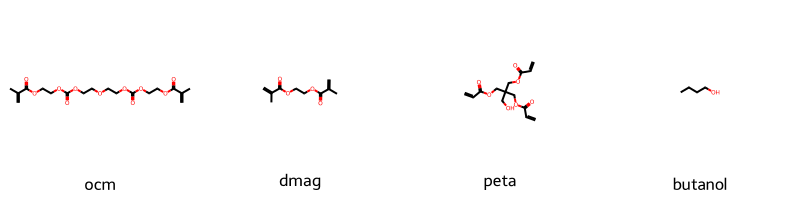

In [47]:
class MolNames(Enum):
    butanol = 'but'
    ocm = 'ocm'
    dmag = 'dmg'
    peta = 'pet'



RD_MOLECULES = {
    MolNames.ocm:
    Chem.MolFromSmiles("CC(C(OCCOC(OCCOCCOC(OCCOC(C(C)=C)=O)=O)=O)=O)=C"),
    MolNames.dmag: Chem.MolFromSmiles("C=C(C)C(OCCOC(C(C)=C)=O)=O"),
    MolNames.peta: Chem.MolFromSmiles("C=CC(OCC(COC(C=C)=O)(COC(C=C)=O)CO)=O"),
    MolNames.butanol: Chem.MolFromSmiles("OCCCC"),
}

OFF_MOLECULES = {}
for molecule_type, rdkit_mol in RD_MOLECULES.items():
    mol = toolkit.Molecule.from_rdkit(rdkit_mol)
    OFF_MOLECULES[molecule_type] = mol
    mol.generate_conformers(n_conformers=1)
    mol.name = molecule_type.value

    for atom in mol.atoms:
        atom.metadata["residue_name"] = molecule_type.value.upper()
    mol.add_hierarchy_scheme(
        iterator_name="residue",
        uniqueness_criteria=["residue_name"],
    )

Draw.MolsToGridImage(
    RD_MOLECULES.values(),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in RD_MOLECULES.keys()],
)

In [48]:
class Box:
    box = None
    ff = toolkit.ForceField("openff_unconstrained-2.1.0.offxml")

    def __init__(self, x, rho, substance: MolNames):
        self.solvent_n = int(x)
        self.substance_n = int((100 - x))
        self.substance = substance
        self.rho = rho

    def __repr__(self) -> str:
        return f"<Box: {self.substance}= {self.substance_n} ({self.solvent_n}), rho={self.rho} mg/cm3>"

    def pack(self, tol=0.5):
        solvent = OFF_MOLECULES[MolNames.butanol]
        substance = OFF_MOLECULES[self.substance]
        if self.substance_n == 0:
            molecules = [solvent]
            n_molecules = [100]
        elif self.substance_n == 100:
            molecules = [substance]
            n_molecules = [100]
        else:
            molecules = [solvent, substance]
            n_molecules = [self.solvent_n, self.substance_n]
        self.box = pack_box(
            molecules=molecules,
            number_of_copies=n_molecules,
            mass_density=self.rho * unit.kilogram / unit.meter**3,
            tolerance=tol * unit.angstrom,
            box_shape=UNIT_CUBE,
        )

    def parametrize(self):
        self.system = interchange.Interchange.from_smirnoff(
            force_field=self.ff,
            topology=self.box,
        )

    def minimaze(self):
        self.system.minimize()

    def save(self, path):
        with open(path, "w") as file:
            box_j = self.box.to_json()
            data = {
                "solvent_n": self.solvent_n,
                "substance": self.substance,
                "rho": self.rho,
            }
            box_j = f"{data} ###" + box_j
            file.write(box_j)

    @classmethod
    def load(cls, path):
        with open(path, "r") as file:
            box_j = file.read()
            data, box_j = box_j.split("###")
            data = eval(data)
            box = Box(
                x=int(data["solvent_n"]),
                rho=data["rho"],
                substance=data["substance"],
            )
            box.box = toolkit.Topology.from_json(box_j)

        return box

In [49]:
res = {
    MolNames.butanol: [
        (100, 700),
    ],
    MolNames.dmag: [
        (0, 1069),
        (11, 1069),
        (22, 1050),
        (35, 1029),
        (39, 1019),
    ],
    MolNames.ocm: [
        (0, 1720),
        (12, 1580),
        (22, 1569),
        (31, 1550),
        (38, 1539),
        (44, 1530),
        (49, 1510),
        (54, 1489),
        (58, 1490),
    ],
    MolNames.peta: [
        (0, 1200),
        (19, 1180),
        (30, 1159),
        (41, 1140),
        (49, 1110),
    ],
}

In [53]:
boxes: list[Box] = []
i = 0
for substance, combinations in res.items():
    for x, rho in combinations:
        i += 1
        save_path = Path(f"./boxes/box_{substance.name}_{x}_{rho}.json")
        if save_path.exists():
            continue

        box = Box(
            x=x,
            rho=rho,
            substance=substance,
        )
        for i in [2, 1, 0.5, 0.2, 0.1]:
            try:
                box.pack(tol=1)
                box.save(path=save_path.as_posix())
                break
            except Exception as e:
                print(e)
                pass

        for i in range(5):
            try:
                box.rho -= 50
                box.pack(tol=0.1)
                box.save(path=save_path.as_posix())
                print(f'{save_path.name:30}: rho {box.rho}')
                break
            except Exception as e:
                print(e)
                pass
        else:
            print(f'{save_path.name:30}: Full error')

boxes

box_butanol_100_700.json      : rho 650


[]

# Simulation

In [114]:
class MSDReporter:

    def __init__(self, interval, simulation, dt):
        self.interval = interval
        self.dt = dt.value_in_unit(openmm.unit.second)
        self.ids = {}

        self.data = {'Time': np.array([])}
        self.atom_map = {}
        self.positions = {}
        self.start_positions = {}

        self.residues = list({residue.name for residue in simulation.topology.residues()})
        state0 = simulation.context.getState(getPositions=True, enforcePeriodicBox=False)
        atoms = list(simulation.topology.atoms())
        for residue_name in self.residues:
            atom_ids = [
                atoms.index(atom) for atom in atoms if MSDReporter.is_selected(atom, residue_name)
            ]

            self.atom_map[residue_name] = atom_ids

            positions = state0.getPositions(asNumpy=True).value_in_unit(openmm.unit.centimeter)
            self.start_positions[residue_name] = positions[atom_ids]

            self.data.update({residue_name: np.array([])})

    @staticmethod
    def is_selected(
        atom: openmm.app.topology.Atom,
        residue: str,
    ):
        selected_atoms = [openmm.app.Element.getBySymbol(symbol) for symbol in ['O', 'C', 'N']]

        select_residue = atom.residue.name == residue
        select_atom = atom.element in selected_atoms
        return select_residue and select_atom

    def describeNextReport(self, simulation):
        steps = self.interval - simulation.currentStep % self.interval
        return (steps, True, False, False, False, False)

    def report(self, simulation, state):
        for residue in self.residues:
            atom_ids = self.atom_map[residue]
            positions = state.getPositions(asNumpy=True).value_in_unit(openmm.unit.centimeter)[
                atom_ids
            ]
            start_positions = self.start_positions[residue]

            msd = np.mean(np.linalg.norm((start_positions - positions), axis=1) ** 2)
            self.data[residue] = np.append(self.data[residue], msd)
        time = state.getStepCount() * self.dt
        self.data['Time'] = np.append(self.data['Time'], time)

    @property
    def df(self):
        return pd.DataFrame(self.data)


def create_simulation(
    box: Box,
    dt=1,
    T=25,
    check_freq=100,
    save_dir: Path = Path("simulations"),
):
    # Integration options
    dt = dt * openmm.unit.femtoseconds  # simulation timestep
    temperature = (T + 273) * openmm.unit.kelvin  # simulation temperature
    friction = 1 / openmm.unit.picosecond  # friction constant

    integrator = openmm.LangevinIntegrator(temperature, friction, dt)
    simulation = box.system.to_openmm_simulation(
        integrator=integrator,
        # platform=openmm.Platform.getPlatformByName('CUDA'),
    )
    # simulation.context.setVelocitiesToTemperature(temperature)
    substance = box.substance
    x = box.substance_n
    rho = box.rho

    sim_dir = save_dir / Path(f"box_{substance}_{x}_{rho}")
    sim_dir.mkdir(parents=True, exist_ok=True)
    box.system.to_pdb(f"{sim_dir}/box_min.pdb")

    equilibration = tqdm(iterable=range(10))
    equilibration.set_description_str('Equilibration')
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperature)
    simulation.context.reinitialize(preserveState=True)

    for i in equilibration:
        simulation.step(check_freq)

    msdReporter = MSDReporter(check_freq, simulation, dt)
    simulation.reporters.append(msdReporter)
    simulation.currentStep = 0
    return simulation, msdReporter

In [115]:
check_freq=100
simulation, msdReporter = create_simulation(b, dt=1,check_freq = check_freq)

product_cycle = tqdm(iterable=range(100))
product_cycle.set_description_str('Product')
for i in product_cycle:
    simulation.step(check_freq)

Product: 100%|██████████| 100/100 [00:18<00:00,  5.45it/s]


# Lib

In [12]:
import simulator
from tqdm import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
box = simulator.Box.load("boxes/box_butanol_100_1000.json")
box.parametrize()
box.minimaze()

In [3]:
simulation,reporter = simulator.create_simulation(box)

Equilibration: 100%|██████████| 10/10 [00:00<00:00, 12.43it/s]


In [7]:
product_cycle = tqdm(iterable=range(100))
product_cycle.set_description_str('Product')
for i in product_cycle:
    simulation.step(100)

Product: 100%|██████████| 100/100 [00:08<00:00, 12.35it/s]


BUT:  0.60 cm2/day)


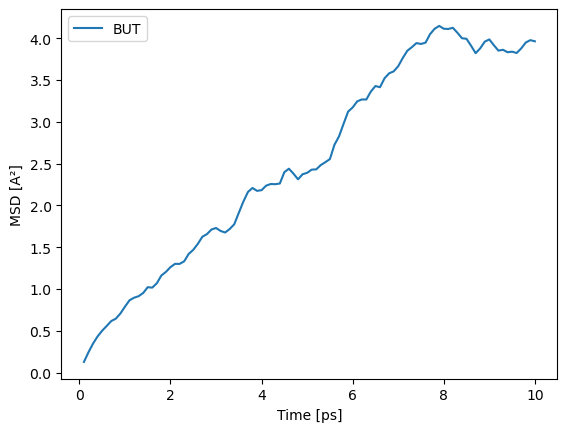

In [13]:
df = reporter.df

for mol_type in list(df.columns)[1:]:
    linear_model = linregress(df['Time'], df[mol_type])
    slope = linear_model.slope
    plt.plot(df['Time']*10**12, df[mol_type]*10**16,label=mol_type)
    D = slope / 6*24*60*60
    print(f'{mol_type}: {D: >5.2f} cm2/day)')

plt.xlabel('Time [ps]')
plt.ylabel('MSD [A²]')
plt.legend();